In [1]:
from skimage import io, filters, color, measure
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

plt.rcParams['figure.figsize'] = [12, 8]

# Import the image and convert to greyscale

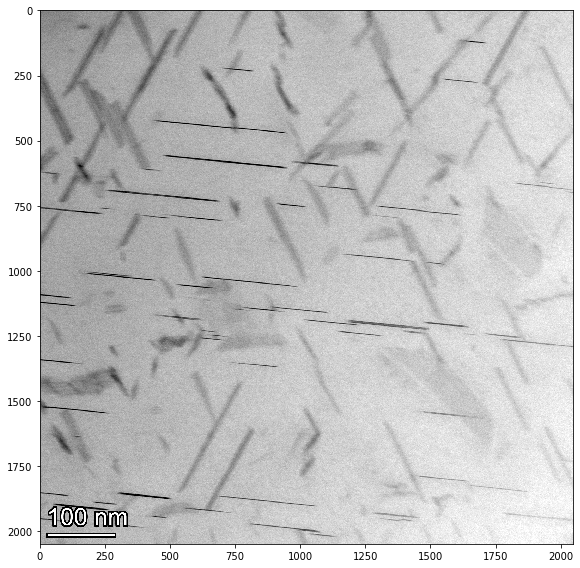

In [2]:
image = io.imread("easy_bf.png")
gray_image = color.rgb2gray(color.rgba2rgb(image))
io.imshow(gray_image)
plt.show()

## Mask the scale bar

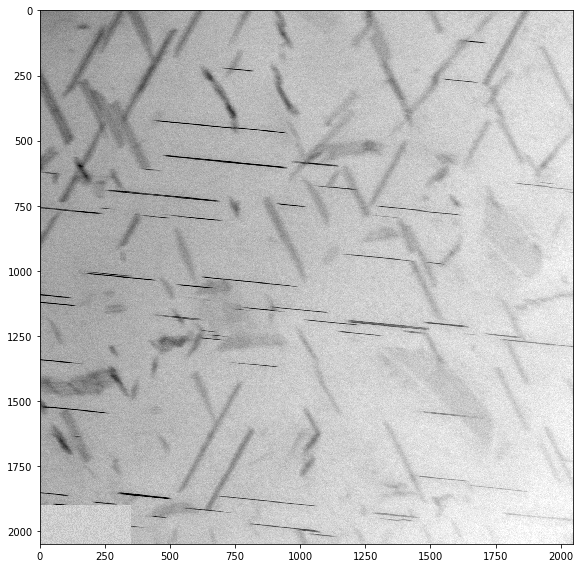

In [3]:
x_min = 0
x_max = 350
y_min = gray_image.shape[1] - 150
y_max = gray_image.shape[1]
patch_floor = np.average(gray_image)
patch_variance = np.std(gray_image)

patch = np.random.rand(y_max-y_min, x_max-x_min) * patch_variance + patch_floor

gray_image[y_min:y_max, x_min:x_max] = patch
io.imshow(gray_image)

## Denoise the image with a difference of Gaussians

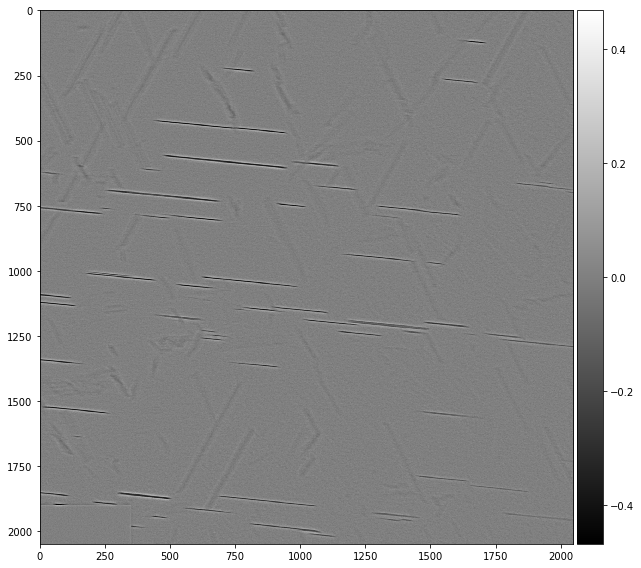

In [4]:
small_gaussian = 1
large_gaussian = 5

denoised_image = filters.difference_of_gaussians(gray_image, small_gaussian, large_gaussian)
io.imshow(denoised_image, cmap=plt.cm.gray)

## Apply Otsu threshold to binarise

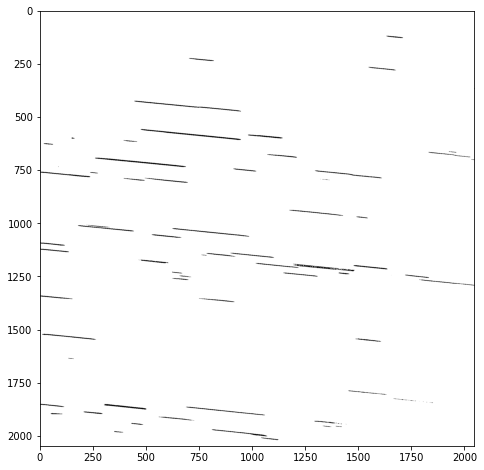

In [5]:
threshold = filters.threshold_otsu(denoised_image)
binary_image = denoised_image > threshold
plt.imshow(binary_image, cmap=plt.cm.gray)
plt.show()

## Label contiguous regions

c:\users\peter\documents\git\rod finder\venv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


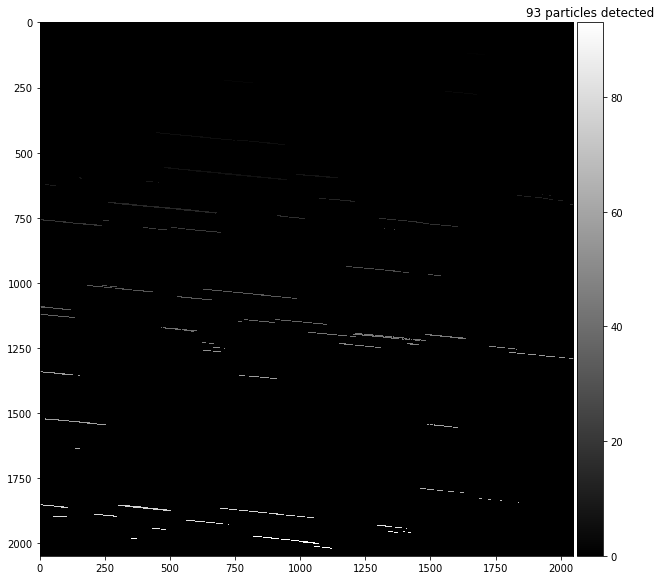

In [6]:
labeled_image, num_particles = measure.label(binary_image, background=1, return_num=True)
io.imshow(labeled_image, cmap=plt.cm.gray)
plt.title(f"{num_particles} particles detected")
plt.show()

## Get data on labelled regions
Plot a plot with the rod ends, center and length labelled

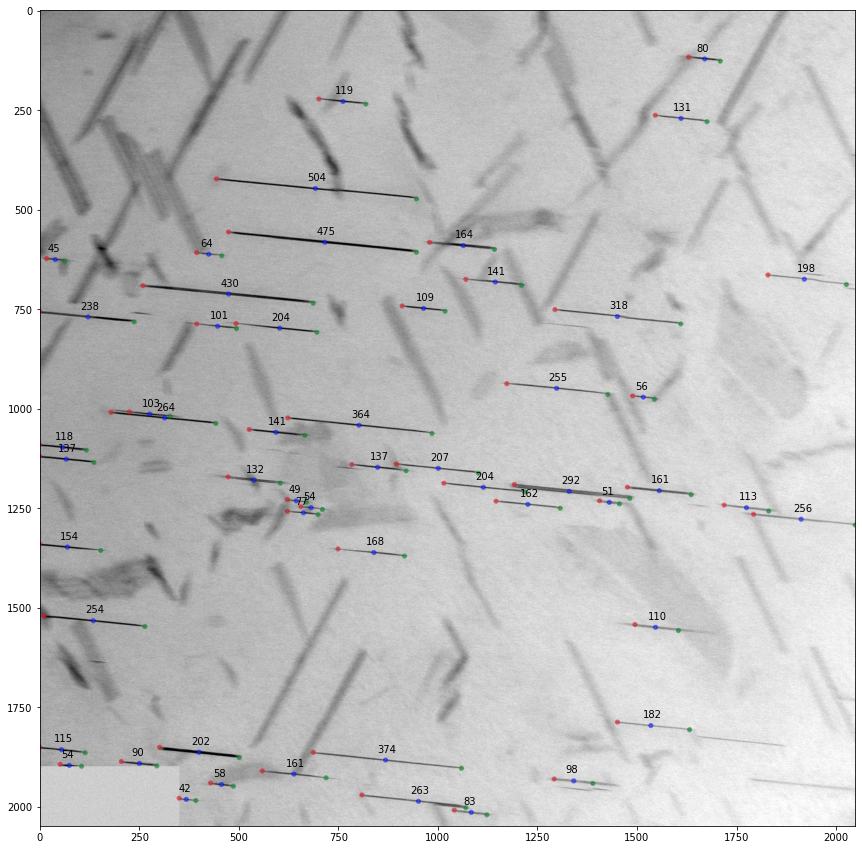

In [7]:
region_data = measure.regionprops(labeled_image)

fig, ax = plt.subplots(figsize=[20, 15])
ax.imshow(gray_image, cmap=plt.cm.gray)

circle_size = 4

for region in region_data:
    if region.area > 100:
        center = mpatches.Circle((region.centroid[1], region.centroid[0]), circle_size, edgecolor='blue', alpha=0.5, linewidth=2)
        ax.add_patch(center)
        left_end = mpatches.Circle((region.bbox[1], region.bbox[0]), circle_size, edgecolor='red', alpha=0.5, linewidth=2)
        ax.add_patch(left_end)
        right_end = mpatches.Circle((region.bbox[3], region.bbox[2]), circle_size, edgecolor='green', alpha=0.5, linewidth=2)
        ax.add_patch(right_end)
        rod_length = np.sqrt((region.bbox[2] - region.bbox[0]) ** 2 + (region.bbox[3] - region.bbox[1]) ** 2)
        plt.text(region.centroid[1] - 20, region.centroid[0] - 20, f"{rod_length:0.0f}")
plt.show()

## Count lengths

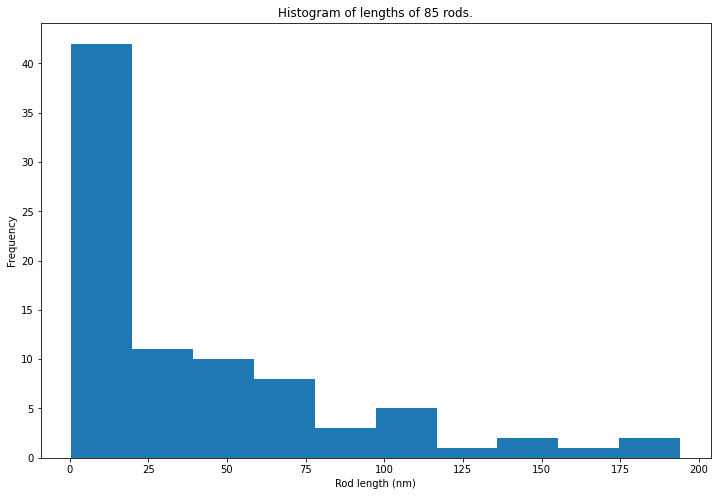

In [8]:
# 1 nm = 2.6 pixels

edge_radius = 10
rod_lengths = []

for region in region_data:
    left_y = region.bbox[0]
    left_x = region.bbox[1]
    right_y = region.bbox[2]
    right_x = region.bbox[3]
    
    if left_x > edge_radius and left_y > edge_radius:
        if right_x < (gray_image.shape[1] - edge_radius) and right_y < (gray_image.shape[0] - edge_radius):
            rod_lengths.append(np.sqrt((region.bbox[2] - region.bbox[0]) ** 2 + (region.bbox[3] - region.bbox[1]) ** 2))

rod_lengths = np.array(rod_lengths) / 2.6

plt.hist(rod_lengths)
plt.title(f"Histogram of lengths of {len(rod_lengths)} rods.")
plt.xlabel("Rod length (nm)")
plt.ylabel("Frequency")
plt.show()